## Data Inspection

This notebook aims to examine the data and collect a set of transformations that are neeed to present the underlying patterns of the data to a machine learning algorithm.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import sys
sys.path.append(os.path.abspath('../configs'))
from config import *

c:\Users\jerem\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import gaussian_kde


In [2]:
df = pd.read_csv('CompiledDataSet/INMS_V0.csv', parse_dates=['TIME'])
df.head()

,sclk,targ_pos_x,targ_pos_y,targ_pos_z,source,coadd_cnt,velocity_comp,alt_t,view_dir_t_x,view_dir_t_y,...,sc_pos_t_z,sc_vel_t_x,sc_vel_t_y,sc_vel_t_z,c1counts,c2counts,TIME,FLYBY,TIME_FROM_CA,TRAINING_SUBSET
0,2011-274T12:52:35.027,-5833.0,-238668.0,13.0,osi,1,7.5,26691.861,0.960030,-0.279784,...,-132.97,7.754,-0.77,-0.061,0,0,2011-10-01 12:52:35.027,E14,-59.999550,False
1,2011-274T12:52:35.061,-5834.0,-238668.0,13.0,osi,1,7.5,26691.601,0.960030,-0.279786,...,-132.97,7.754,-0.77,-0.061,0,0,2011-10-01 12:52:35.061,E14,-59.998983,False
2,2011-274T12:52:35.095,-5835.0,-238668.0,13.0,osi,1,7.5,26691.341,0.960029,-0.279788,...,-132.97,7.754,-0.77,-0.061,0,0,2011-10-01 12:52:35.095,E14,-59.998417,False
3,2011-274T12:52:35.129,-5836.0,-238668.0,13.0,osi,1,7.5,26691.081,0.960028,-0.279790,...,-132.97,7.754,-0.77,-0.061,0,0,2011-10-01 12:52:35.129,E14,-59.997850,False
4,2011-274T12:52:35.163,-5837.0,-238668.0,13.0,osi,1,7.5,26690.821,0.960028,-0.279792,...,-132.97,7.754,-0.77,-0.061,0,0,2011-10-01 12:52:35.163,E14,-59.997283,False


Let us first inspect how many datapoints are covered within an 30s interval (duration of plume flythrough)

In [5]:
flybys = {
    "E3" : "2008-03-12 19:07:00",
    "E5" : "2008-10-09 19:07:22",
    "E7" : "2009-11-02 07:42:10",
    "E14": "2011-10-01 13:52:35",
    "E17": "2012-03-27 18:30:15",
    "E18": "2012-04-14 14:01:45",
    "E21": "2015-10-28 15:22:55",
}
ca_times = {k: pd.to_datetime(v) for k, v in flybys.items()}

results = []
for flyby, ca_time in ca_times.items():
    dff = df[df['FLYBY'] == flyby].copy()
    dff = dff.dropna(subset=['TIME'])
    dff['DELTAT_SCLK'] = (dff['TIME'] - ca_time).dt.total_seconds()
    count = (dff['DELTAT_SCLK'].abs() <= 30).sum()
    results.append((flyby, count))

print(pd.DataFrame(results, columns=["Flyby", "Points_±30s"]))

  Flyby  Points_±30s
0    E3         1763
1    E5         1763
2    E7         1763
3   E14         1763
4   E17         1764
5   E18         1763
6   E21         1764


The number of data points greatly exceeds the CDA Dataset, let us track if we imported the correct data and if the count numbers show an increase during plume flybys.

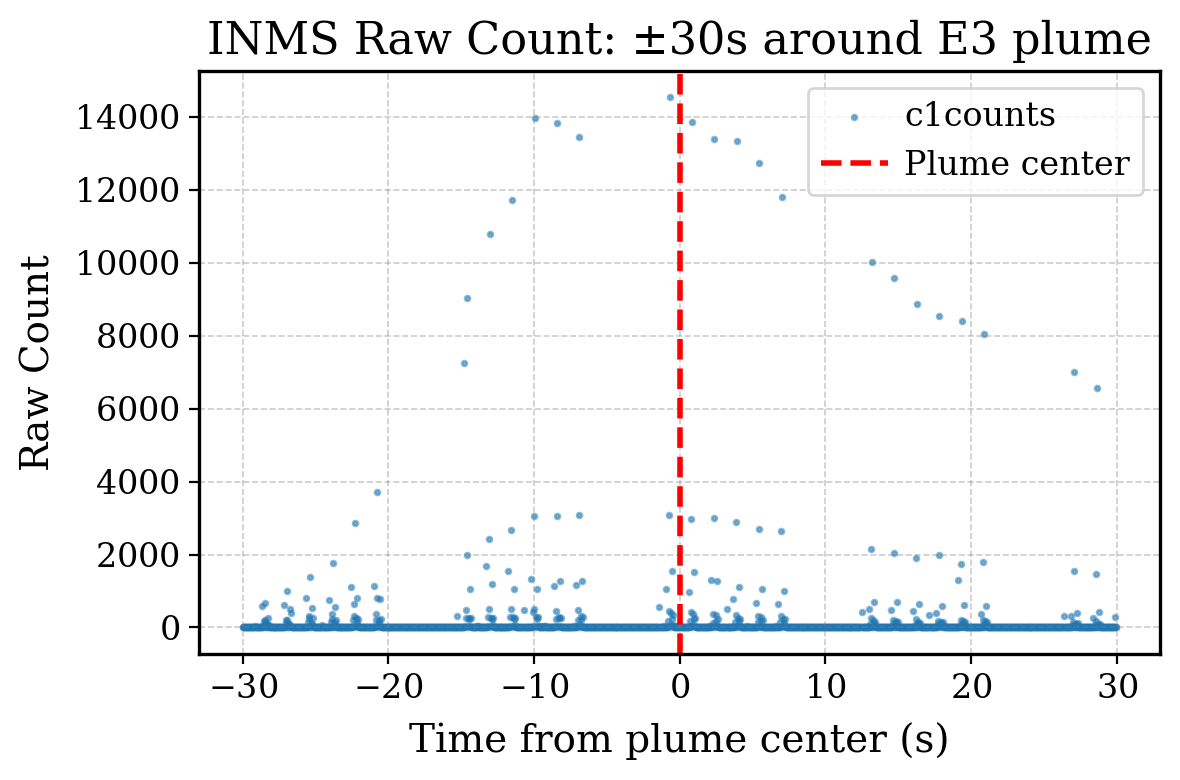

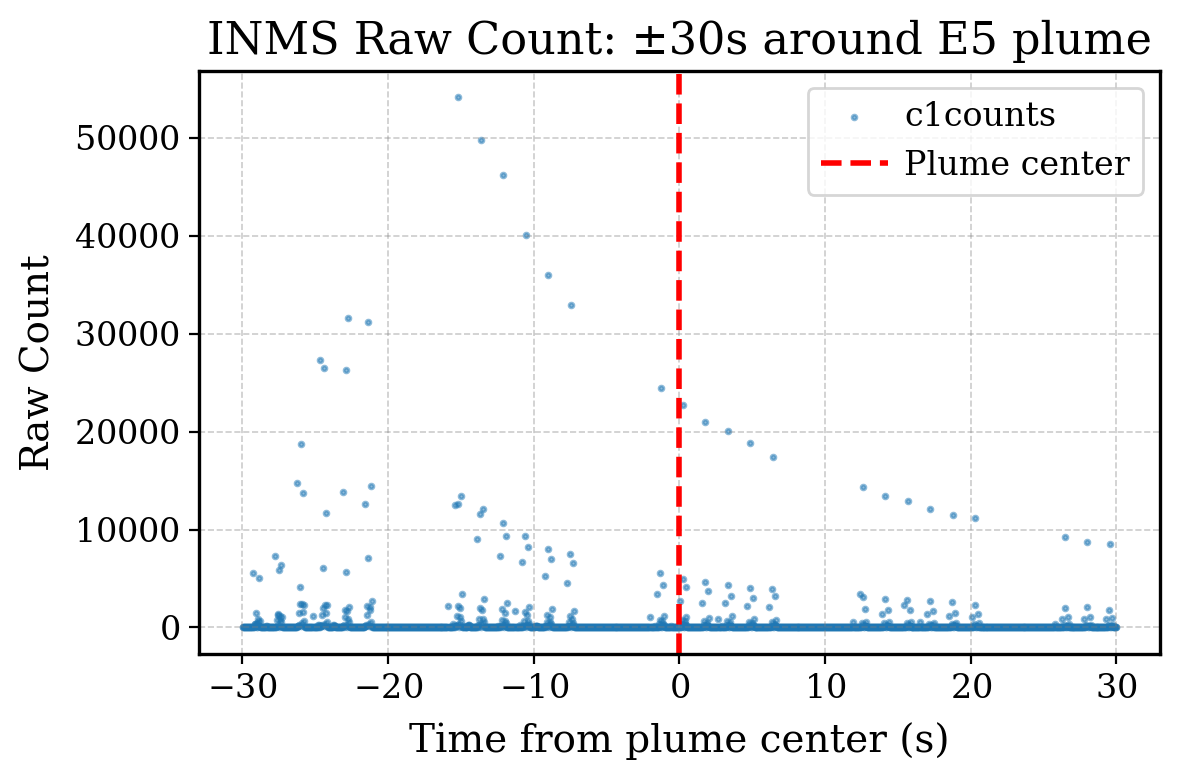

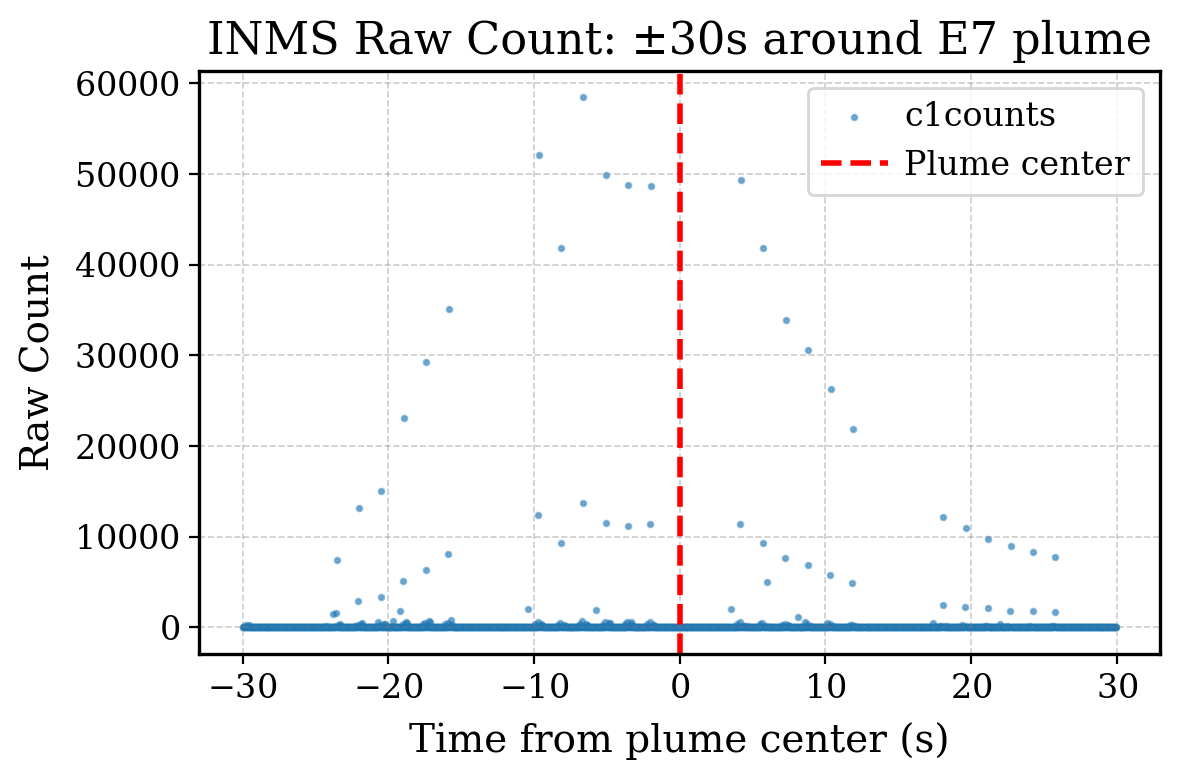

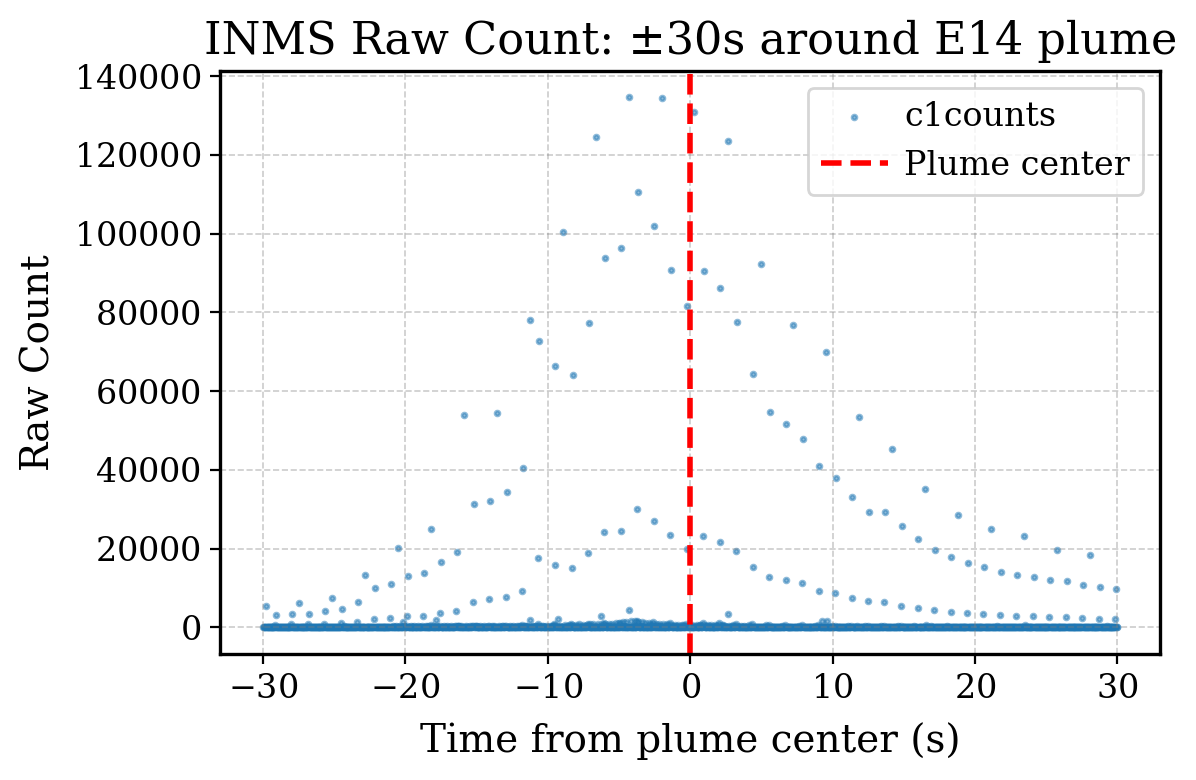

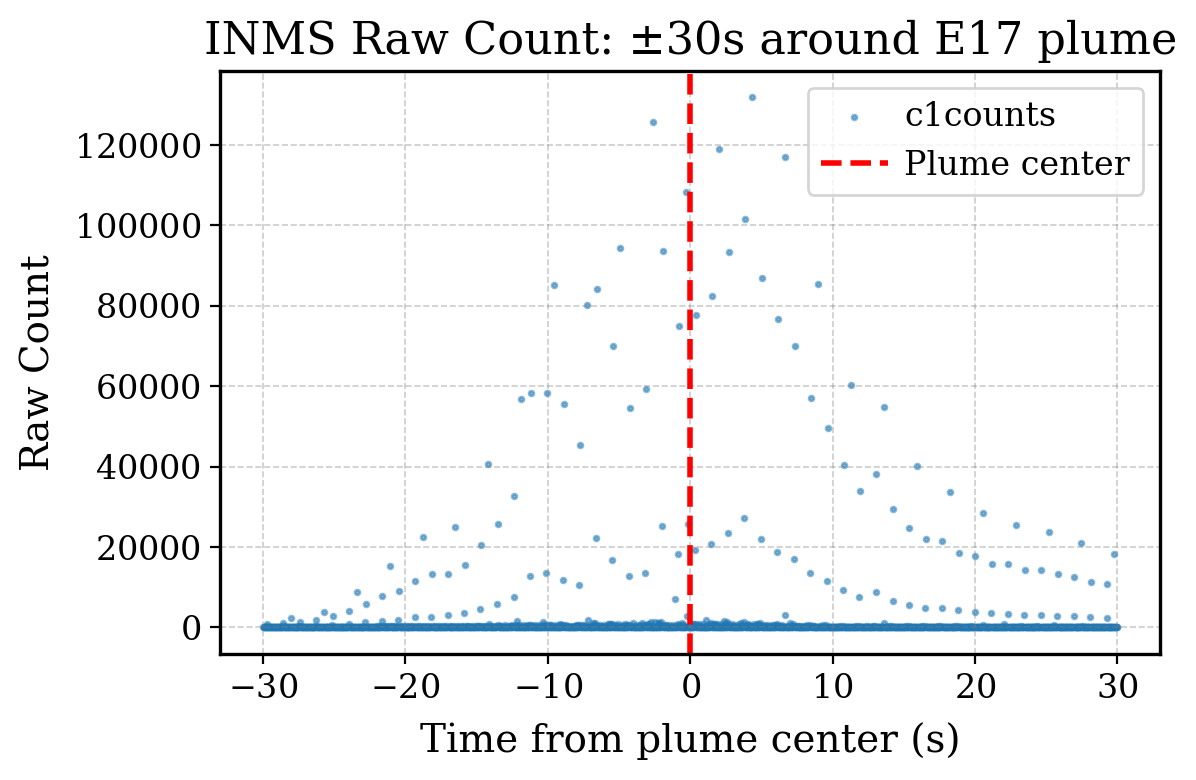

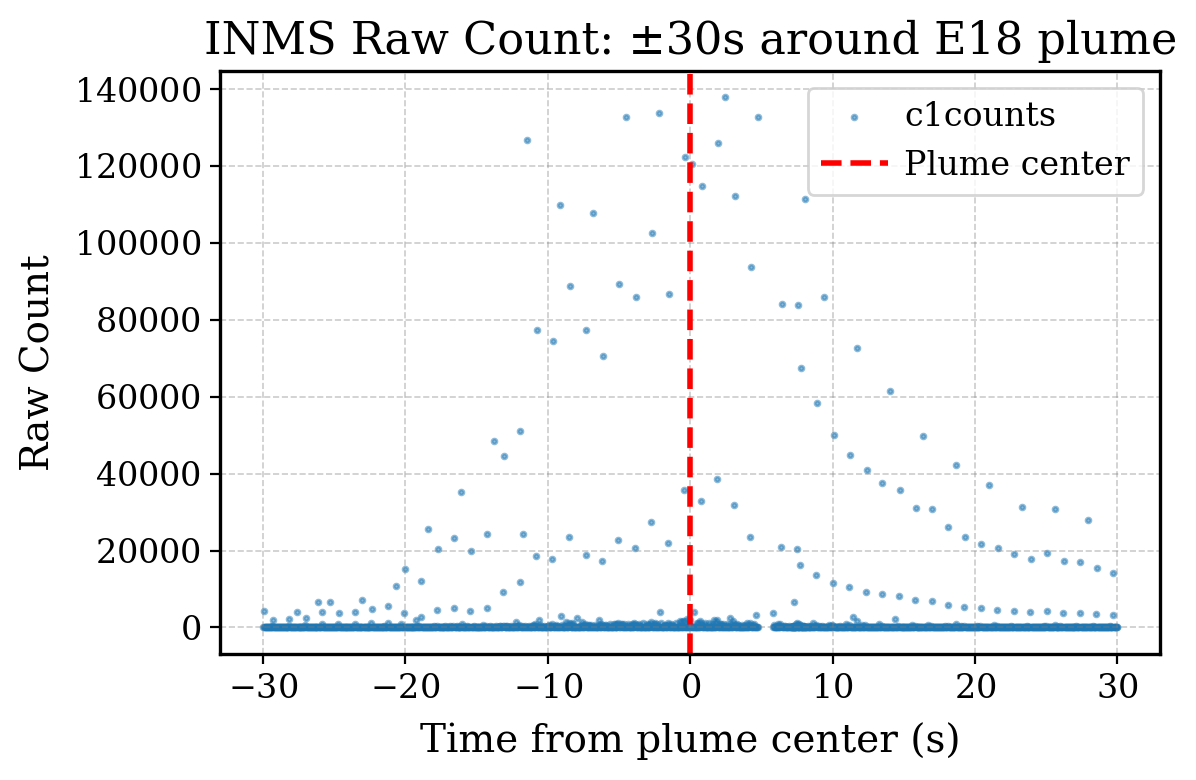

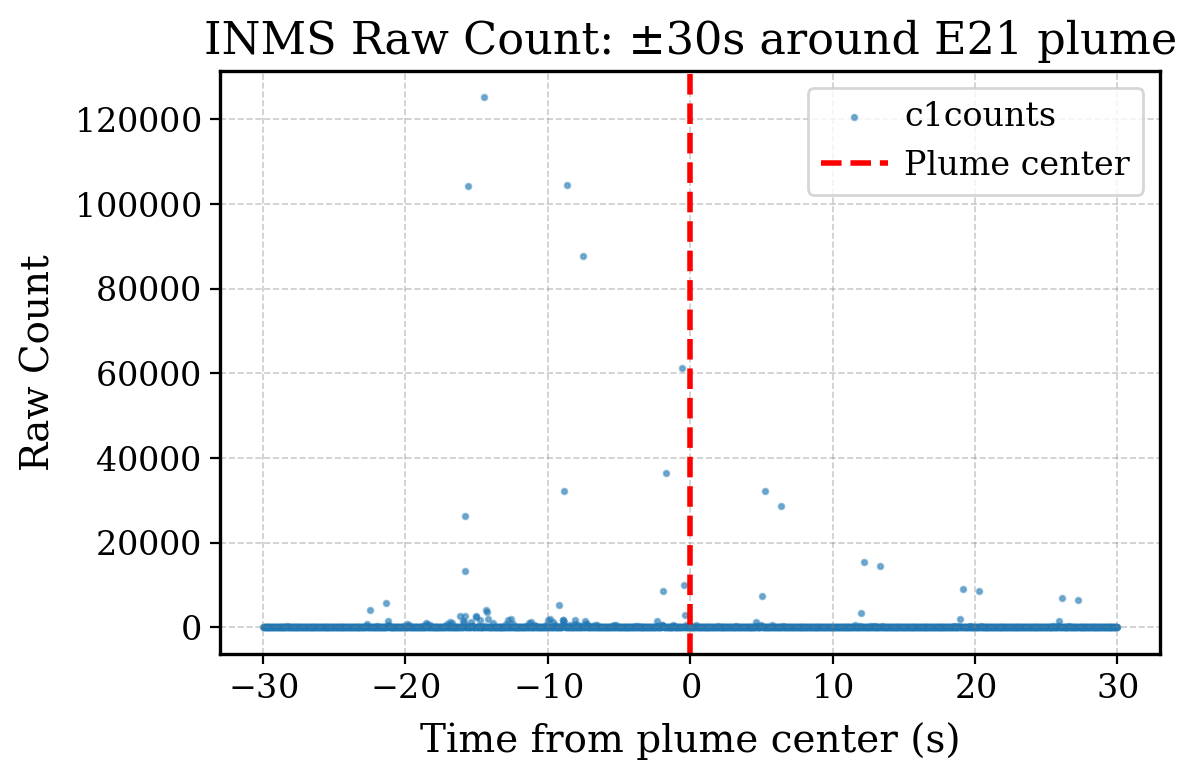

In [6]:
# flybys = {
#     "E14": "2011-10-01 13:52:35",
# }

for flyby, ca_time_str in flybys.items():
    ca_time = pd.to_datetime(ca_time_str)
    dff = df[df['FLYBY'] == flyby].dropna(subset=['TIME']).copy()
    dff['DELTAT_SCLK'] = (dff['TIME'] - ca_time).dt.total_seconds()
    window = dff[dff['DELTAT_SCLK'].abs() <= 30]

    plt.figure(figsize=(6, 4))
    plt.scatter(window['DELTAT_SCLK'], window['c1counts'], s=3, alpha=0.5, label='c1counts')
    plt.axvline(0, color='r', linestyle='--', label='Plume center')
    plt.title(f'INMS Raw Count: ±30s around {flyby} plume')
    plt.xlabel('Time from plume center (s)')
    plt.ylabel('Raw Count')
    plt.legend(loc="best")
    #plt.savefig("Figures/plumewindow.pdf",dpi=200)
    plt.show()

In contrast to the CDA dataset, we found that we now a good plume coverage, meaning we move toward to feature analysis. However, as also stated in literature, E21 plume has low SNR. However, we will keep it for future reference.

In [7]:
df.describe()

,targ_pos_x,targ_pos_y,targ_pos_z,coadd_cnt,velocity_comp,alt_t,view_dir_t_x,view_dir_t_y,view_dir_t_z,sc_pos_t_x,sc_pos_t_y,sc_pos_t_z,sc_vel_t_x,sc_vel_t_y,sc_vel_t_z,c1counts,c2counts,TIME,TIME_FROM_CA
count,1.423993e+06,1.423993e+06,1.423993e+06,1.478462e+06,1.475334e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.423993e+06,1.478462e+06,1.478462e+06,1478462,1.478462e+06
mean,-7.242600e+04,6.971561e+04,-1.408279e+01,1.001059e+00,8.499880e+00,1.783734e+04,3.399830e-01,-4.939566e-02,-4.752130e-03,5.818658e+02,-5.799044e+02,-3.570146e+02,1.021998e+00,-3.721588e-01,-4.327498e+00,1.684146e+01,1.037010e-01,2011-04-10 22:23:09.708040192,-2.927640e-02
min,-2.364330e+05,-2.386680e+05,-5.500000e+01,1.000000e+00,2.750000e+00,2.857600e+01,-9.999750e-01,-9.449130e-01,-9.615990e-01,-3.087249e+04,-2.962951e+04,-5.617496e+04,-8.732000e+00,-5.735000e+00,-1.567000e+01,0.000000e+00,0.000000e+00,2008-03-12 18:07:00,-6.000000e+01
25%,-1.533650e+05,-1.931480e+05,-2.800000e+01,1.000000e+00,7.500000e+00,7.589482e+03,1.195900e-02,-4.482530e-01,-1.858200e-02,-7.513500e+03,-5.061780e+03,-5.788000e+02,-6.821000e+00,-3.833000e+00,-1.342800e+01,0.000000e+00,0.000000e+00,2008-10-09 19:37:33.833499904,-3.002974e+01
50%,-7.743600e+04,1.725340e+05,-1.100000e+01,1.000000e+00,7.500000e+00,1.565144e+04,4.297740e-01,-1.279470e-01,-7.996000e-03,7.804900e+02,-2.489600e+02,-3.479400e+02,3.449000e+00,-1.980000e+00,-9.800000e-02,0.000000e+00,0.000000e+00,2011-10-01 13:52:57.594000128,-1.522500e-02
75%,2.940000e+02,2.294040e+05,2.000000e+00,1.000000e+00,8.500000e+00,2.431677e+04,8.997490e-01,2.521880e-01,9.833900e-02,9.496520e+03,5.015290e+03,-8.703000e+01,6.232000e+00,2.932000e+00,-6.000000e-02,1.000000e+00,0.000000e+00,2012-04-14 13:31:44.793999872,2.996078e+01
max,1.632310e+05,2.391720e+05,1.800000e+01,3.000000e+01,2.900000e+01,6.319835e+04,9.999480e-01,9.798630e-01,1.000000e+00,2.884737e+04,2.798068e+04,5.541305e+04,7.815000e+00,8.306000e+00,1.230000e-01,1.378310e+05,5.600000e+01,2015-10-28 16:22:45.989000,6.000000e+01
std,9.947961e+04,1.921554e+05,2.093662e+01,1.752597e-01,2.537158e+00,1.334472e+04,6.320822e-01,5.118728e-01,4.694763e-01,1.251538e+04,8.899423e+03,1.638987e+04,6.067633e+00,4.402876e+00,6.624280e+00,8.230222e+02,3.863888e-01,NaN,3.462358e+01


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478462 entries, 0 to 1478461
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   sclk             1478462 non-null  object        
 1   targ_pos_x       1423993 non-null  float64       
 2   targ_pos_y       1423993 non-null  float64       
 3   targ_pos_z       1423993 non-null  float64       
 4   source           1478462 non-null  object        
 5   coadd_cnt        1478462 non-null  int64         
 6   velocity_comp    1475334 non-null  float64       
 7   alt_t            1423993 non-null  float64       
 8   view_dir_t_x     1423993 non-null  float64       
 9   view_dir_t_y     1423993 non-null  float64       
 10  view_dir_t_z     1423993 non-null  float64       
 11  sc_pos_t_x       1423993 non-null  float64       
 12  sc_pos_t_y       1423993 non-null  float64       
 13  sc_pos_t_z       1423993 non-null  float64       
 14  sc

In [9]:
def analyze_noise(s):
    """Detects common types of noise: stochastic outliers, rounding errors or spike artifacts."""

    n = len(s)
    s = s.dropna()
    noise = []

    # Stochastic outliers (3 sigma)
    if np.issubdtype(s.dtype, np.number) and n > 0:
        std = s.std()
        mean = s.mean()
        abs_outliers = ((s - mean).abs() > 3 * std).sum()
        if abs_outliers > 0.05 * n:
            noise.append("Stochastic outliers")

    
    # Rounding artifacts
    if np.issubdtype(s.dtype, np.floating) and n > 0:
        rounded = np.isclose(s, np.round(s), atol=1e-8).sum()
        if rounded > 0.9 * n:
            noise.append("Rounding artifacts")

    
    # Spike artifact with majority single values
    
    val_counts = s.value_counts(dropna=False)
    if (val_counts / n > 0.5).any():
        noise.append("Spike/Mode artifact")
    return ', '.join(noise) if noise else "None"

def describe_features(df):
    """Returns a DataFrame summarizing feature statistics and noise."""

    analysis_rows = []
    for col in df.columns:
        s = df[col]
        dtype = s.dtype
        n = len(s)
        n_missing = s.isna().sum()
        percentage_missing = n_missing / n * 100

        # Noise
        noise_type = analyze_noise(s)

        # Row for table
        analysis_rows.append({
            "Feature": col,
            "Type": str(dtype),
            "Missing": f"{n_missing} ({percentage_missing:.2f}%)",
            "Noise": noise_type,
        })
        
    # Summary DataFrame
    return pd.DataFrame(analysis_rows)

analysis_df = describe_features(df)
analysis_df

,Feature,Type,Missing,Noise
0,sclk,object,0 (0.00%),None
1,targ_pos_x,float64,54469 (3.68%),Rounding artifacts
2,targ_pos_y,float64,54469 (3.68%),Rounding artifacts
3,targ_pos_z,float64,54469 (3.68%),Rounding artifacts
4,source,object,0 (0.00%),Spike/Mode artifact
5,coadd_cnt,int64,0 (0.00%),Spike/Mode artifact
6,velocity_comp,float64,3128 (0.21%),None
7,alt_t,float64,54469 (3.68%),None
8,view_dir_t_x,float64,54469 (3.68%),None
9,view_dir_t_y,float64,54469 (3.68%),None


Rounding articatls for the targets position is expected, since it does not change. Spike artifacts for counts, detecter mode and coadd count is natural, as these occur on a rare basis. These missing value counts are the same for most of the geometry features. Since it is only about 3.7% of the data it can likely be removed. Lets see if these nan values occur in the same rows.

In [10]:
# Define geometry/state features
geometry_features = [
    'targ_pos_x', 'targ_pos_y', 'targ_pos_z', 'alt_t',
    'view_dir_t_x', 'view_dir_t_y', 'view_dir_t_z',
    'sc_pos_t_x', 'sc_pos_t_y', 'sc_pos_t_z',
    'sc_vel_t_x', 'sc_vel_t_y', 'sc_vel_t_z'
]

# Create a mask for rows where all geometry features are NaN
all_nan_mask = df[geometry_features].isnull().all(axis=1)
n_all_nan = all_nan_mask.sum()
print(f"Rows where ALL listed geometry features are NaN: {n_all_nan} out of {len(df)} ({n_all_nan/len(df):.2%})")

Rows where ALL listed geometry features are NaN: 54469 out of 1478462 (3.68%)


This matches exactly the number of missing values above, meaning during these timestamps all geometrical features were not tracked. These rows can safely be removed. Now we shall check the distributions of the training subset (10 min interval) around plume flybys to reduce computation.

In [11]:
# # Example plot for report
# mass_to_charge = df["mass_per_charge"]

# plt.figure(figsize=(6, 4), dpi=300)
# plt.boxplot(mass_to_charge, vert=False, notch=False,
#             widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
# plt.title("Outlier example")
# plt.xlabel("Mass per Charge (amu/e)")
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.savefig("Figures/outlierexample.pdf",dpi=300)
# plt.show()

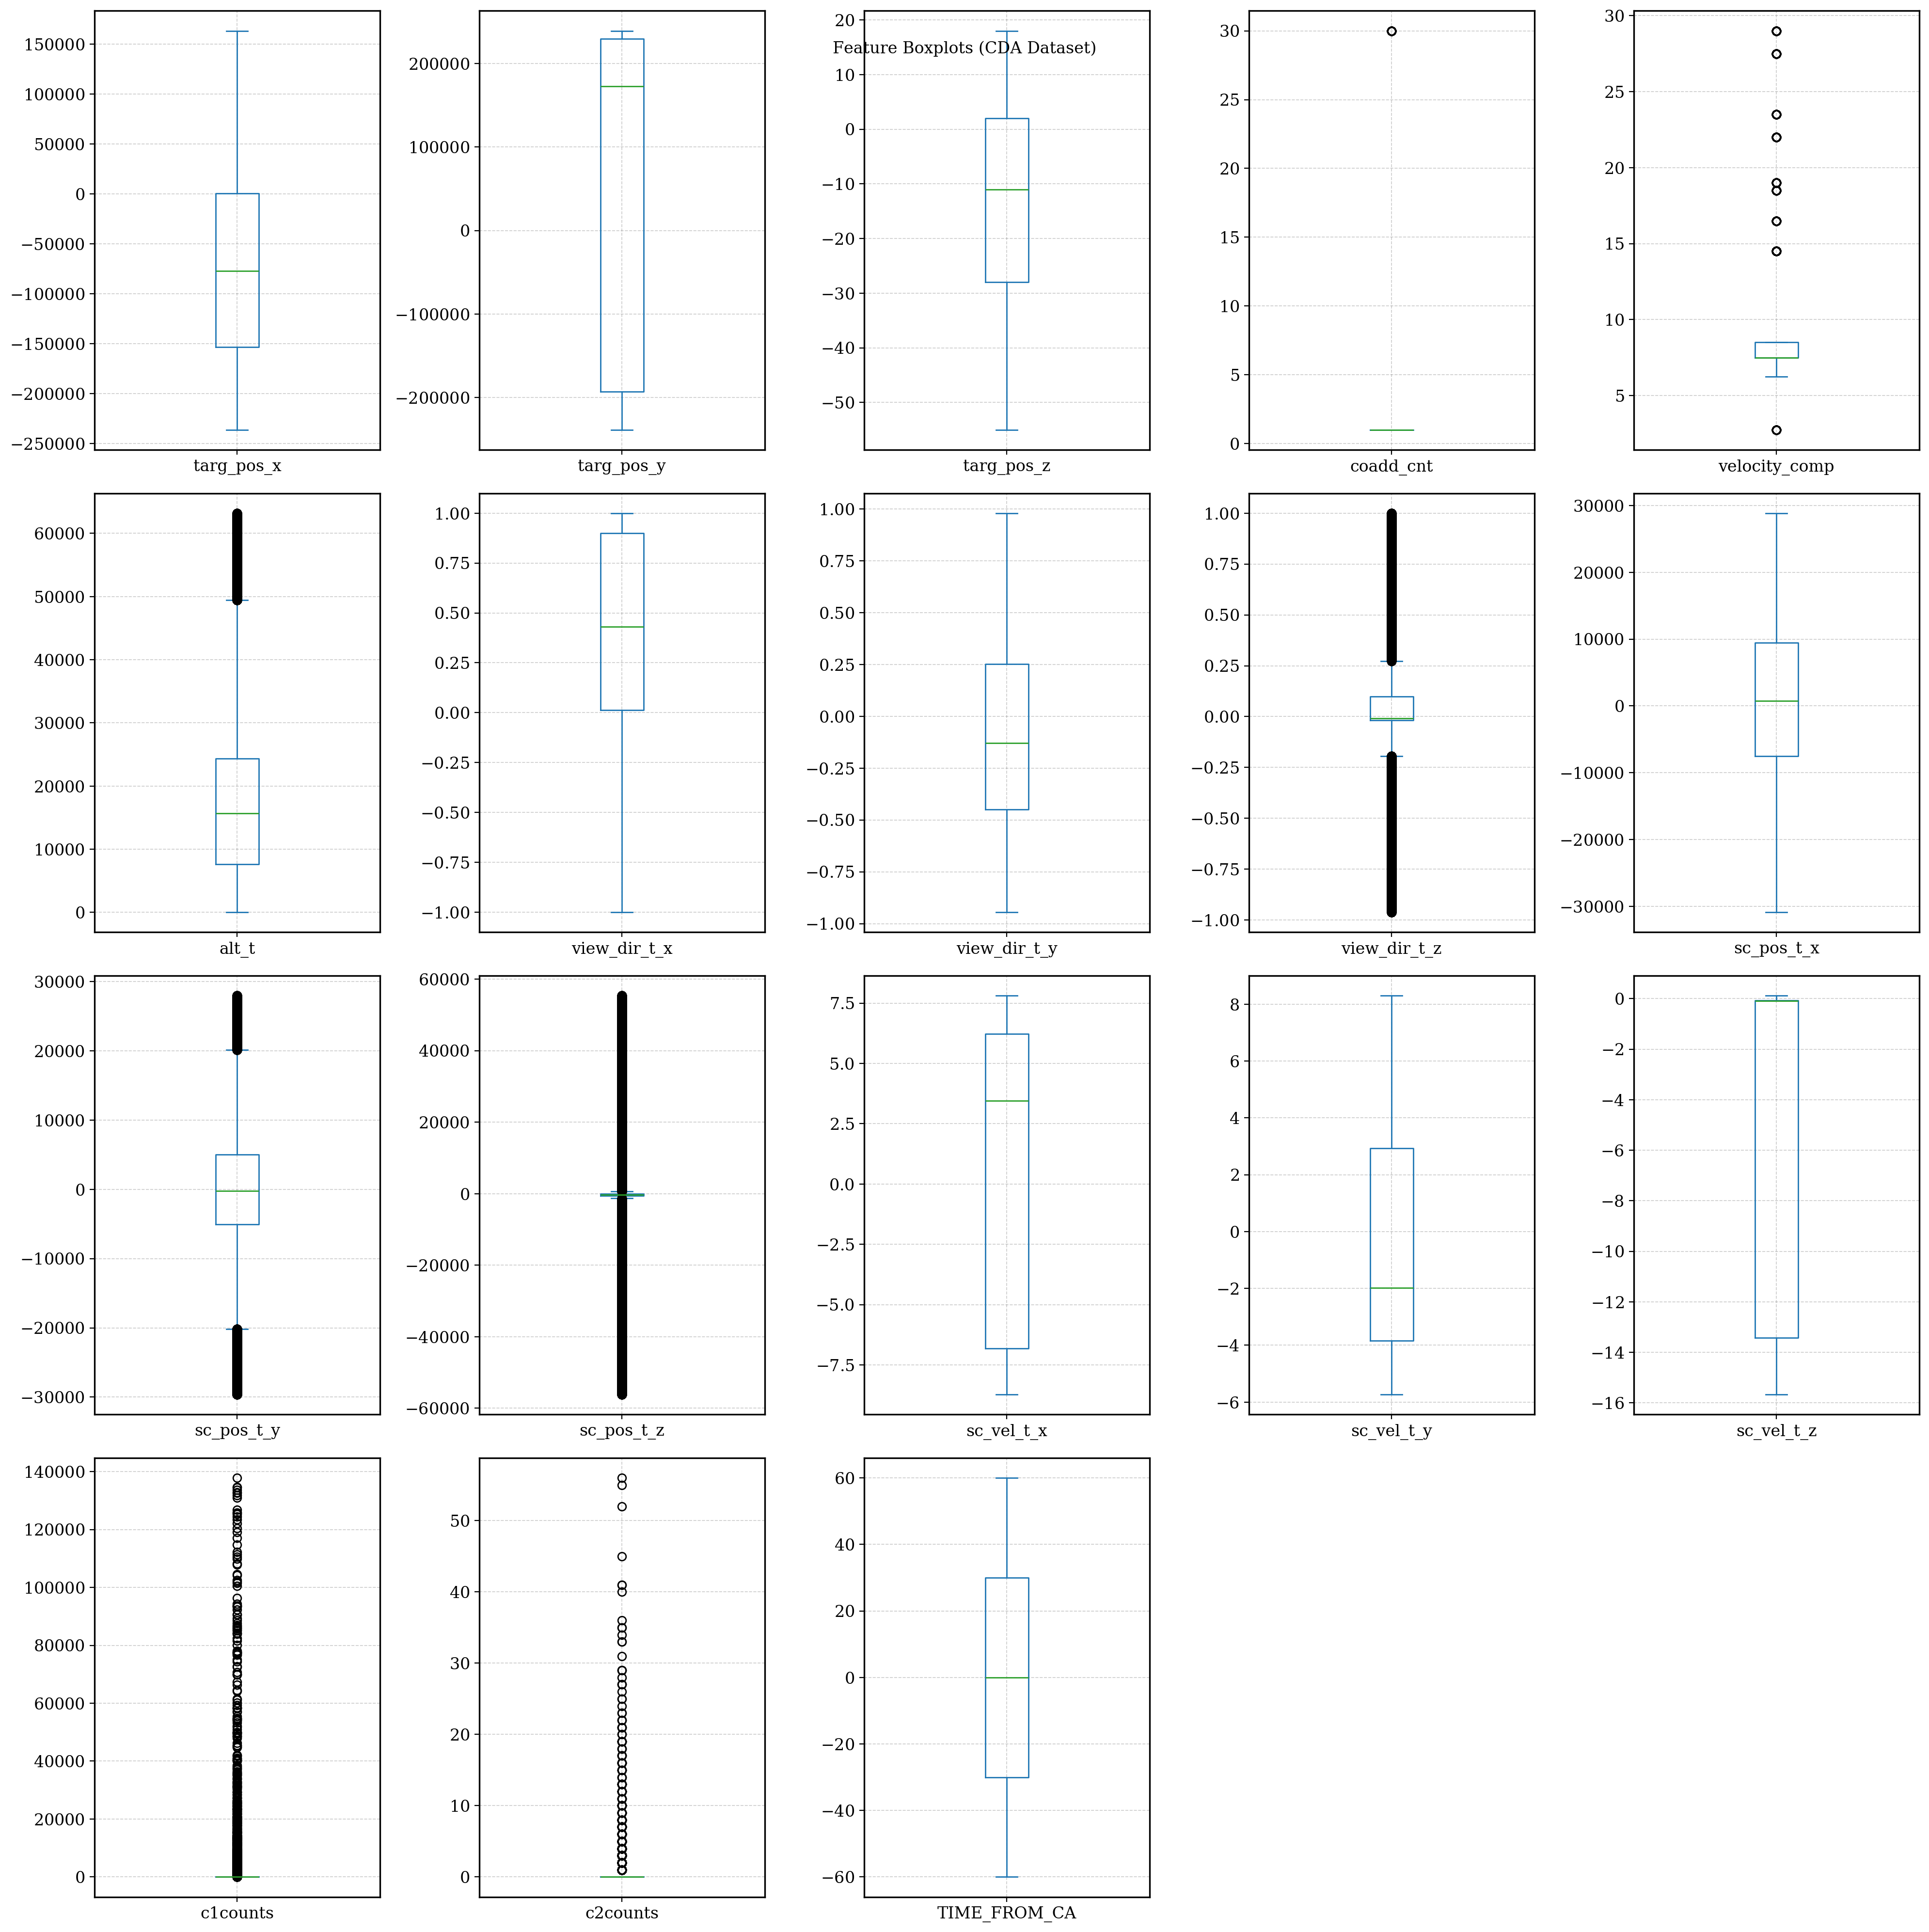

In [12]:
df_num = df.select_dtypes(include="number")

df_num.plot(kind='box', subplots=True, layout=(8, 5), figsize=(20, 40), sharex=False, sharey=False)
plt.suptitle("Feature Boxplots (CDA Dataset)")
plt.show()

- **Coadd count** has an extreme distribution. It describes how many spectra were co added together. We are only interested in the raw spectra so we remove all rows that contain that.
- **velocity comp** has some unexpected high and low velocity, we will cut the 99th quantile.
- **Mass per charge** 1 row with unphysical mass/charge > 250 was removed to avoid contamination.
- **SC positions** has many outliers, but this is expected as we collect more data in the center during plume flybys.
- **c1/c2 counts** Mostly around 0, but with some extreme outliers, where the count data spiked. This is as expected, as those represent the plume.

## Feature Corellation

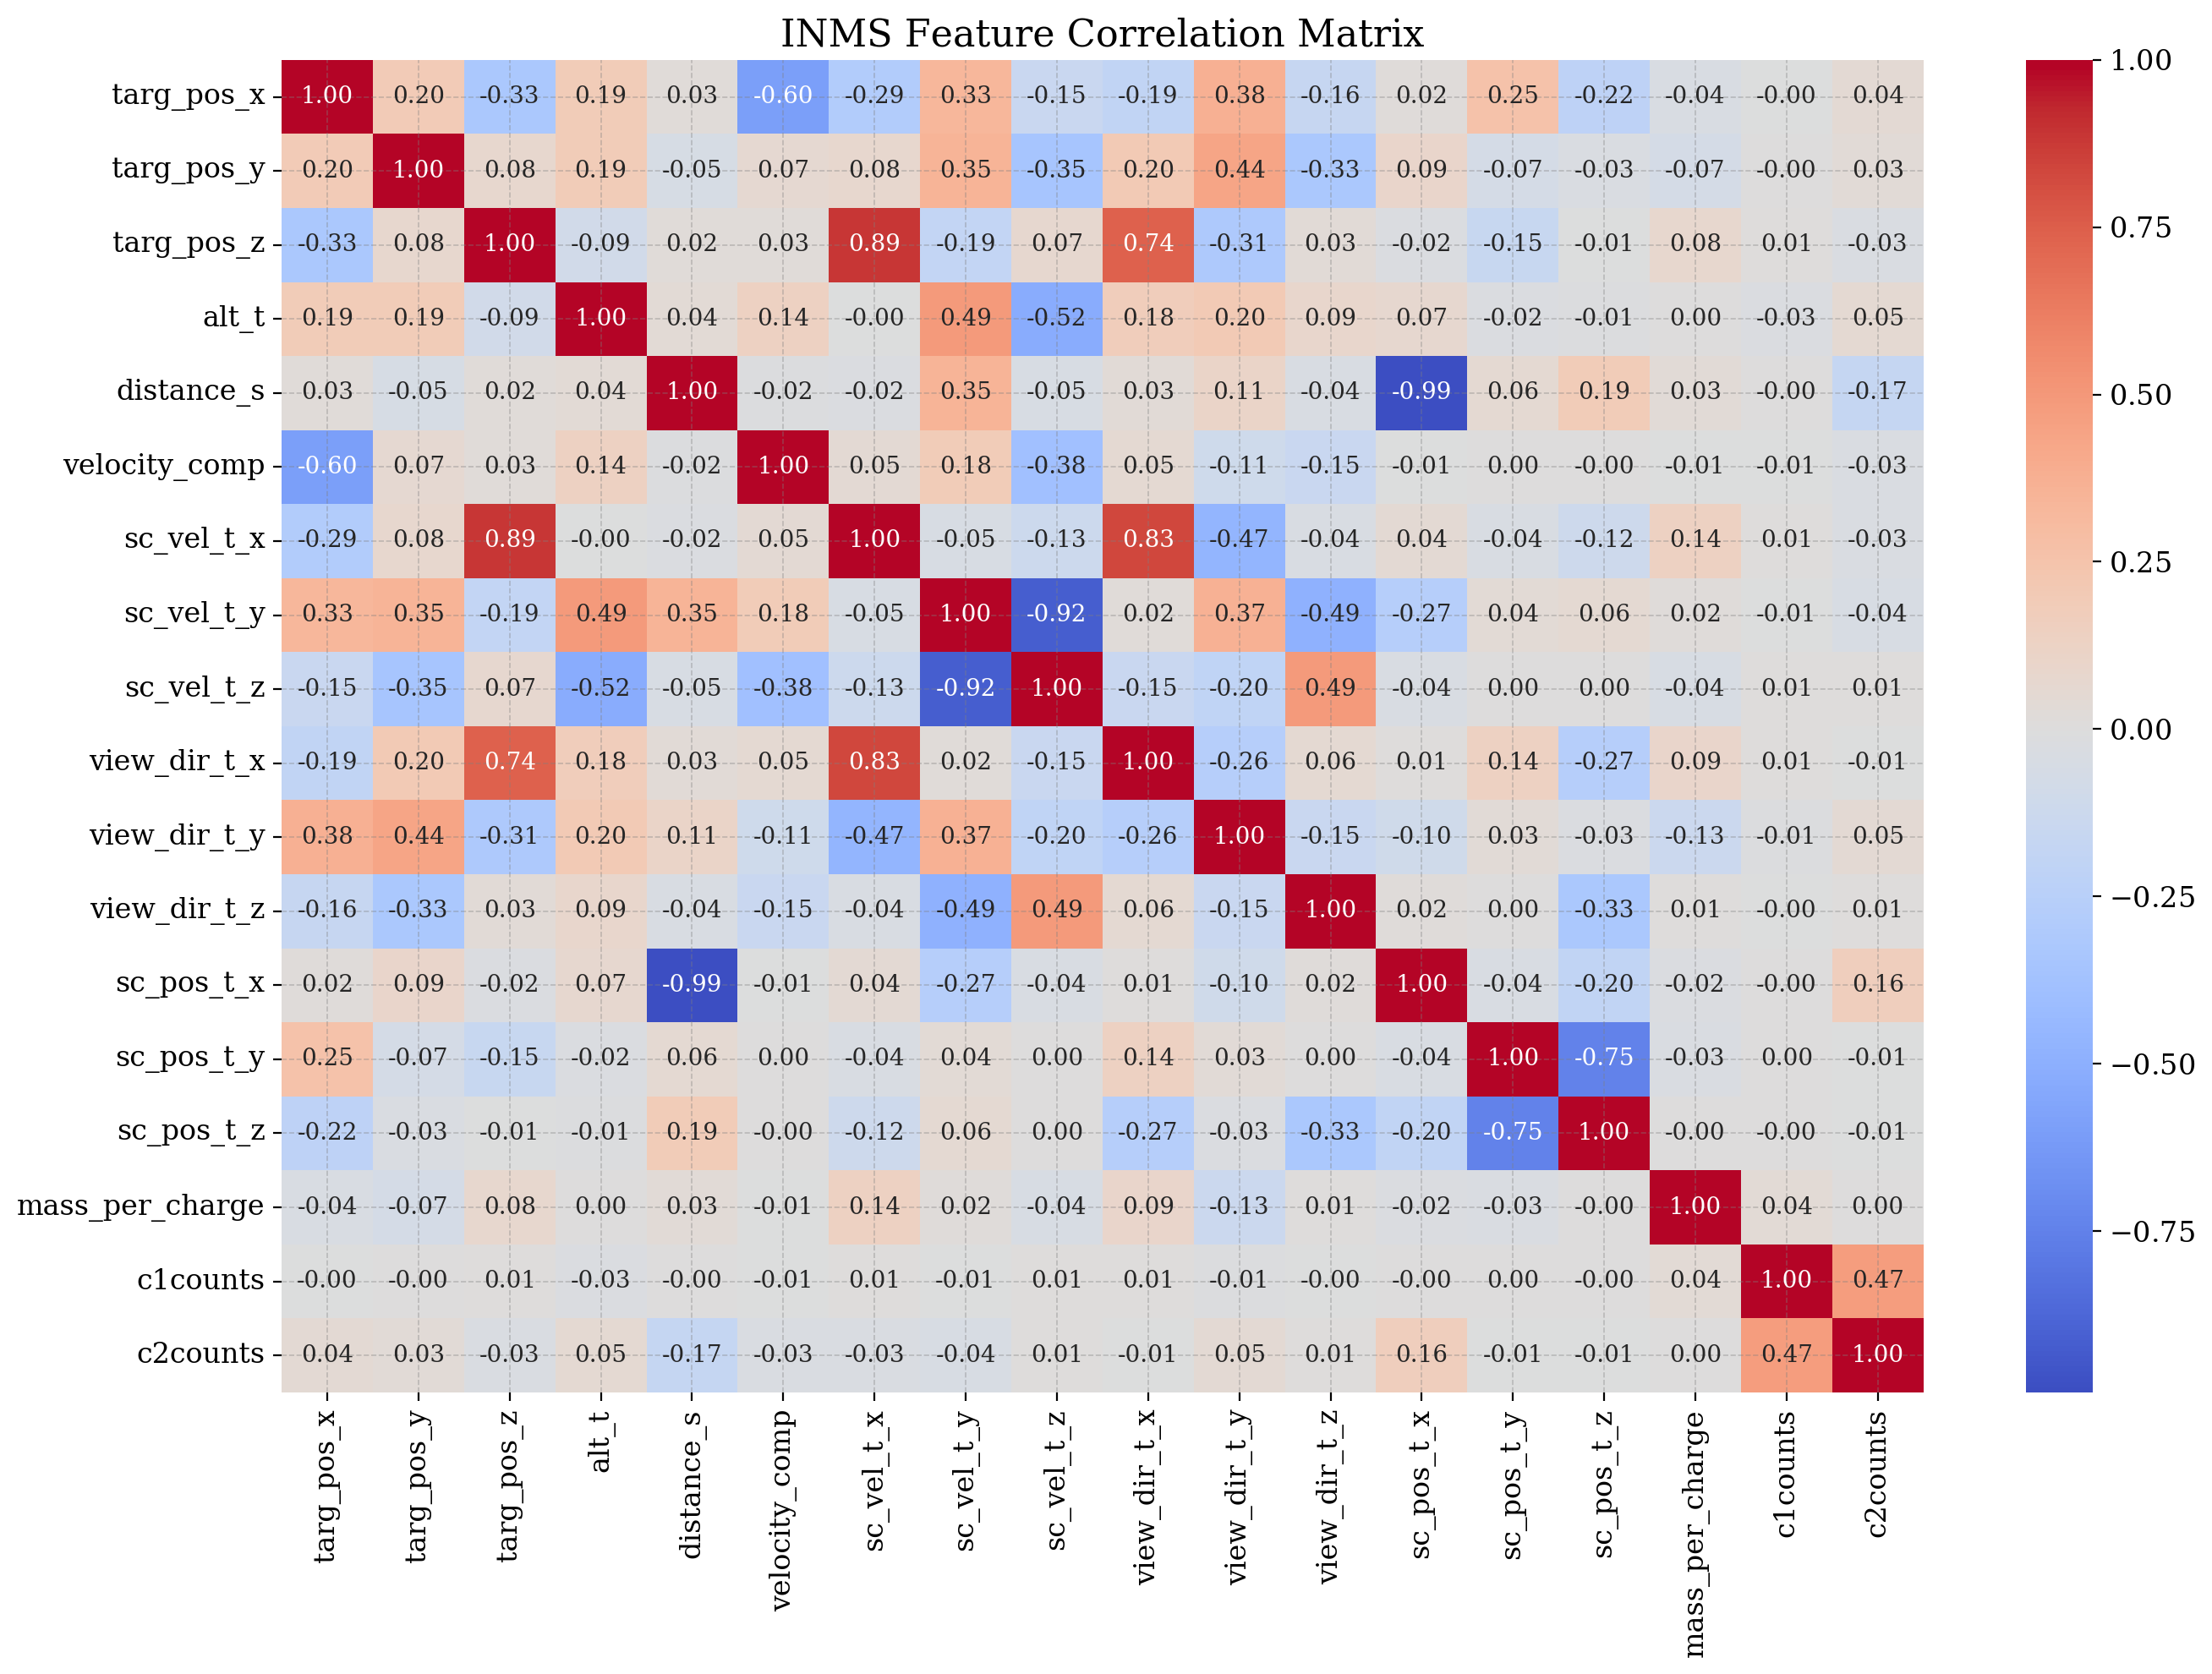

In [5]:
# Select only numeric columns (auto-detect or manual list)
numeric_cols = ['targ_pos_x', 'targ_pos_y', 'targ_pos_z', 'alt_t', 'distance_s',
                'velocity_comp', 'sc_vel_t_x', 'sc_vel_t_y', 'sc_vel_t_z',
                'view_dir_t_x', 'view_dir_t_y', 'view_dir_t_z',
                'sc_pos_t_x', 'sc_pos_t_y', 'sc_pos_t_z',
                'mass_per_charge', 'c1counts', 'c2counts', 'TIME_FROM_CA_MIN']
numeric_cols = [c for c in numeric_cols if c in df.columns]  # in case some missing

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Plot as heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("INMS Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Overall good corellation values, however larger corellation columns (above 0.9) should be sorted out for a higher quality dataset.

## Check if data trafo worked

We used the 03DataTransformation.py script to correct out data. Lets check the new distributions.

In [13]:
# Step 1: Load CSV without parsing dates
df_trafo = pd.read_csv('CompiledDataSet/INMS_V1.csv')

# Step 2: Convert the date column using the correct format
df_trafo['TIME'] = pd.to_datetime(df_trafo['sclk'], format='%Y-%jT%H:%M:%S.%f', errors='coerce')

In [14]:
analysis_df_trafo = describe_features(df_trafo)
analysis_df_trafo

,Feature,Type,Missing,Noise
0,sclk,object,0 (0.00%),None
1,targ_pos_x,float64,0 (0.00%),Rounding artifacts
2,targ_pos_y,float64,0 (0.00%),Rounding artifacts
3,targ_pos_z,float64,0 (0.00%),Rounding artifacts
4,source,object,0 (0.00%),Spike/Mode artifact
5,velocity_comp,float64,0 (0.00%),None
6,mass_per_charge,float64,0 (0.00%),Rounding artifacts
7,alt_t,float64,0 (0.00%),None
8,view_dir_t_x,float64,0 (0.00%),None
9,view_dir_t_y,float64,0 (0.00%),None


No more missing values, a very dense clean dataset.

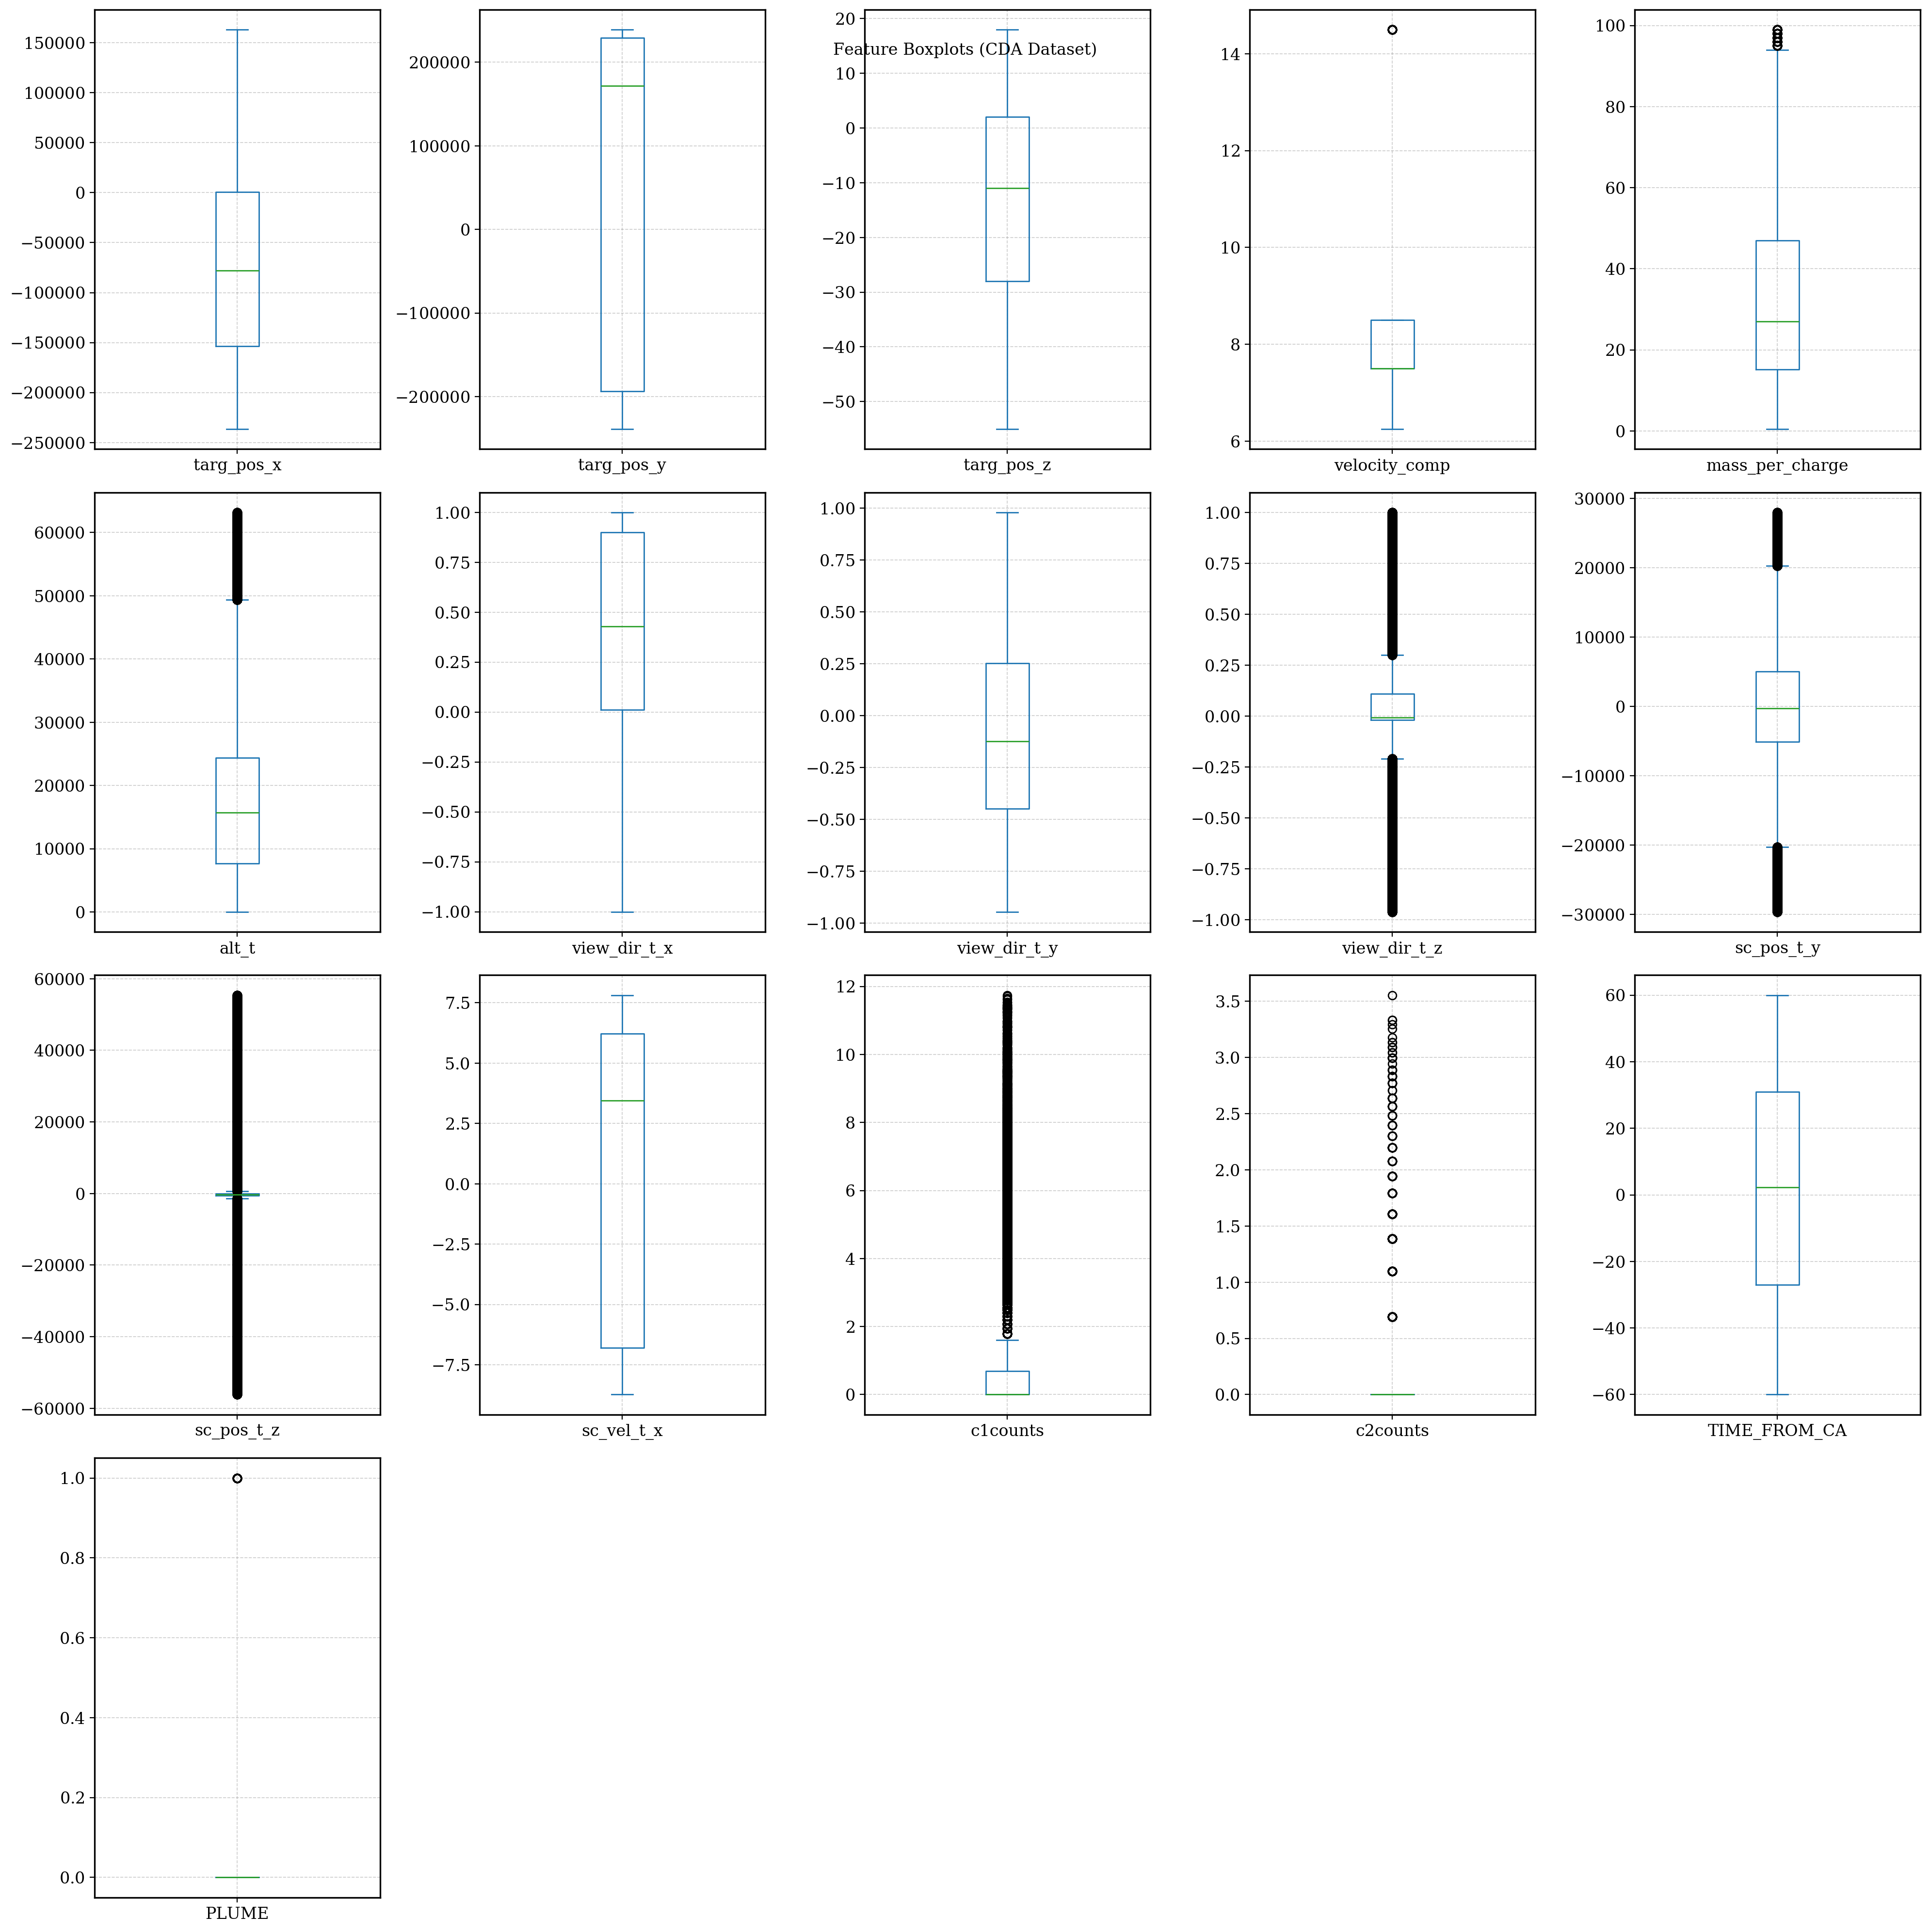

In [31]:
df_trafo_num = df_trafo.select_dtypes(include="number")

df_trafo_num.plot(kind='box', subplots=True, layout=(8, 5), figsize=(20, 40), sharex=False, sharey=False)
plt.suptitle("Feature Boxplots (CDA Dataset)")
plt.show()

Distribution look much better now, however there is still a large outlier in the combined velocities, which is removed in future dataset versions. Log-tranformation on c1count reduces the extreme outliers, but with barely increased counts and future scaling it can be handled by machine learning algorithms.

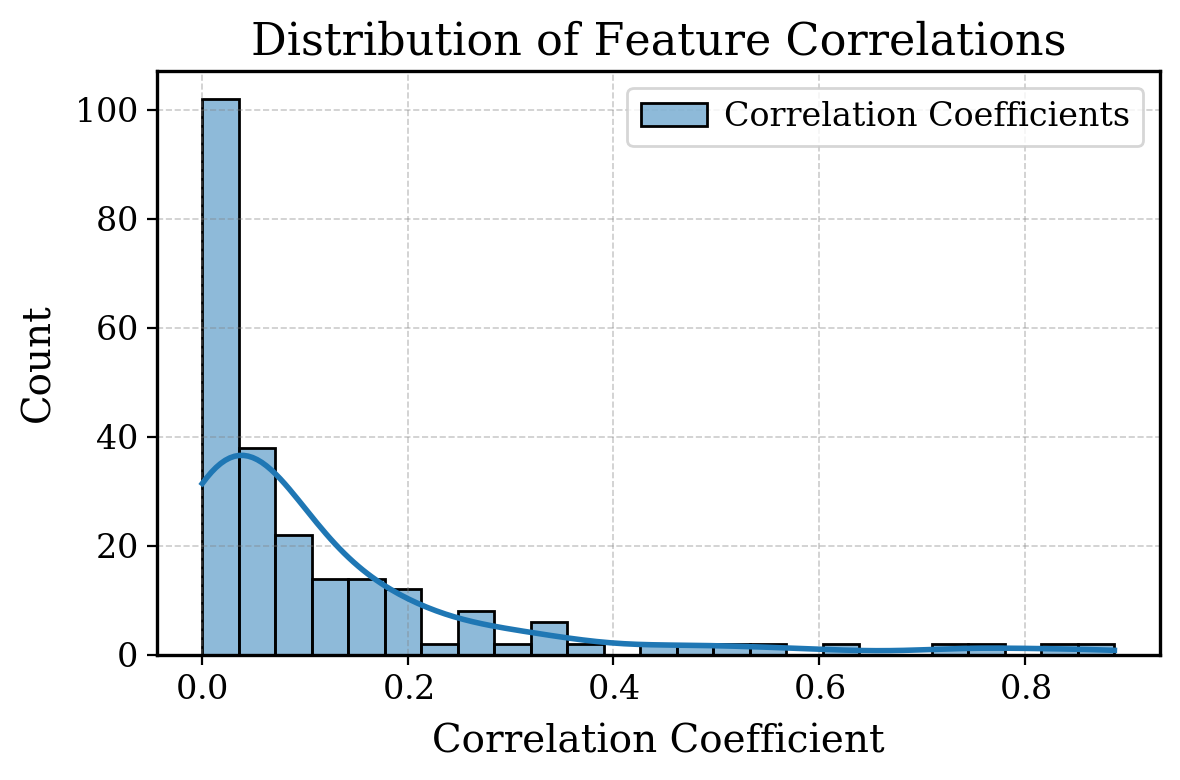

In [34]:
# Correlation distribution
correlation_values = np.abs(df_trafo_num.corr().values.flatten())

# Remove self-correlations (1.0)
correlation_values = correlation_values[correlation_values != 1.0]

# Distribution function plot
plt.figure(figsize=(6, 4))
sns.histplot(correlation_values, bins=25, kde=True, label='Correlation Coefficients')
plt.legend()
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.title("Distribution of Feature Correlations")
plt.savefig("Figures/featurecorellation.pdf",dpi=300)
plt.show()

Overall very good feature corellation, we see some corellations with higher values, but overall small corellation and the data can be handled.